In [19]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.utils import pad_sequences
import numpy as np
import pandas as pd
import re

In [26]:
data=open('sample.txt','r')
sentences = data.read()

In [27]:
sentences

'The speed of transmission is an important point of difference between the two viruses. Influenza has a shorter median incubation period (the time from infection to appearance of symptoms) and a shorter serial interval (the time between successive cases) than COVID-19 virus. The serial interval for COVID-19 virus is estimated to be 5-6 days, while for influenza virus, the serial interval is 3 days. This means that influenza can spread faster than COVID-19. \n\nFurther, transmission in the first 3-5 days of illness, or potentially pre-symptomatic transmission –transmission of the virus before the appearance of symptoms – is a major driver of transmission for influenza. In contrast, while we are learning that there are people who can shed COVID-19 virus 24-48 hours prior to symptom onset, at present, this does not appear to be a major driver of transmission. \n\nThe reproductive number – the number of secondary infections generated from one infected individual – is understood to be betwe

In [28]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [29]:
words = sentences.split()
vocab = set(words)

In [30]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

In [31]:
# Implementation 
# Dictionaries
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [32]:
# DATA BAGS
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['the', 'speed', 'transmission', 'is'], 'of'), (['speed', 'of', 'is', 'an'], 'transmission'), (['of', 'transmission', 'an', 'important'], 'is'), (['transmission', 'is', 'important', 'point'], 'an'), (['is', 'an', 'point', 'of'], 'important')]


In [33]:
# Embeddings¶
embeddings =  np.random.random_sample((vocab_size, embed_dim))

In [34]:
# Linear Model¶
def linear(m, theta):
    w = theta
    return m.dot(w)

In [35]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

In [36]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o
# Backward function
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

In [38]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [42]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [43]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

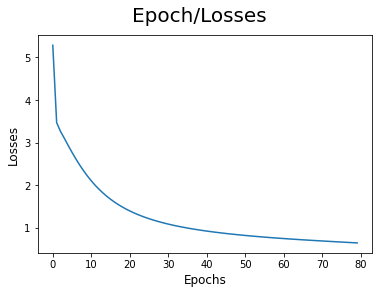

In [45]:
import matplotlib.pyplot as plt
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [46]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [49]:
predict(['speed', 'of', 'is', 'an'])

'transmission'